# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды, используя данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Технологический процесс включает в себя стадию флотации (обогащение), а также две стадии очистки. На выходе каждой стадии получают концентрат и отвальные хвосты.

**Описание данных**

    Технологический процесс
        - Rougher feed — исходное сырье
        - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
        - Rougher process (англ. «грубый процесс») — флотация
        - Rougher tails — отвальные хвосты
        - Float banks — флотационная установка
        - Cleaner process — очистка
        - Rougher Au — черновой концентрат золота
        - Final Au — финальный концентрат золота

    Параметры этапов
        - air amount — объём воздуха
        - fluid levels — уровень жидкости
        - feed size — размер гранул сырья
        - feed rate — скорость подачи

    Наименование признаков
        
        Наименование признаков должно быть такое:
        [этап].[тип_параметра].[название_параметра]
        Пример: rougher.input.feed_ag
    
    Возможные значения для блока [этап]:
        - rougher — флотация
        - primary_cleaner — первичная очистка
        - secondary_cleaner — вторичная очистка
        - final — финальные характеристики
    
    Возможные значения для блока [тип_параметра]:
        - input — параметры сырья
        - output — параметры продукта
        - state — параметры, характеризующие текущее состояние этапа
        - calculation — расчётные характеристики

Модель необходимо оценить на основании метрики качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»)

**План проекта**
    
    1.Подготовка данных
          Посмотрим на исходные данные
          Проверим расчет эффективночти обогащения
          Признаки, недоступные в тестовой выборке
          Предобработка данных
    2. Анализ данных
          Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки
          Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках
          Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах
    3. Модель
          Подготовим признаки для обучения и тестирования
          Определим функцию sMAPE, которая считает метрику качества модели
          Масштабирование данных
          Оценка качества моделей
          Тестирование моделей
    Заключение

## 1. Подготовка данных

### Посмотрим на исходные данные

In [1]:
!pip install catboost
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from numpy.random import RandomState

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format='retina'

In [2]:
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')

In [3]:
def eda(data):
    print(f'Shape: {data.shape}')
    print()
    print('NaNs q-ty:')
    display(data.isna().sum().to_frame().sort_values(by=0, ascending=False).head(10))
    print('% записей с пропусками: ', round(100*(len(data[data.isna().any(axis=1)]) / len(data))))
    print('duplicates:', data.duplicated().sum())
    print()

In [4]:
eda(full)

Shape: (19439, 87)

NaNs q-ty:


,0
secondary_cleaner.output.tail_sol,1748
rougher.input.floatbank11_xanthate,453
rougher.state.floatbank10_e_air,436
primary_cleaner.output.concentrate_sol,370
secondary_cleaner.state.floatbank2_a_air,220
final.output.concentrate_sol,211
rougher.input.feed_size,145
primary_cleaner.output.concentrate_pb,116
primary_cleaner.input.xanthate,104
final.output.tail_pb,101


% записей с пропусками:  17
duplicates: 0



In [5]:
eda(train)

Shape: (14149, 87)

NaNs q-ty:


,0
secondary_cleaner.output.tail_sol,1605
rougher.state.floatbank10_e_air,436
rougher.input.floatbank11_xanthate,428
primary_cleaner.output.concentrate_sol,286
secondary_cleaner.state.floatbank2_a_air,217
final.output.concentrate_sol,211
rougher.input.feed_size,144
primary_cleaner.input.xanthate,100
rougher.input.feed_pb,100
final.output.tail_pb,100


% записей с пропусками:  22
duplicates: 0



In [6]:
eda(test)

Shape: (5290, 53)

NaNs q-ty:


,0
rougher.input.floatbank11_xanthate,25
rougher.input.feed_sol,21
secondary_cleaner.state.floatbank3_a_air,9
rougher.input.floatbank11_sulfate,8
primary_cleaner.input.depressant,5
rougher.input.floatbank10_sulfate,5
primary_cleaner.input.xanthate,4
primary_cleaner.input.sulfate,4
rougher.input.feed_rate,3
secondary_cleaner.state.floatbank2_a_air,3


% записей с пропусками:  1
duplicates: 0



In [7]:
def graph(data, col):

    sns.set()
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    axes[0].set_title(col, fontsize=18)
    axes[1].set_title(col, fontsize=18)
    sns.histplot(data[col], bins=50, kde=True, ax=axes[0])
    axes[0].set(xlabel=None)
    axes[0].set(ylabel=None)
    sns.boxplot(data=data[col], ax=axes[1])
    axes[1].set(xlabel=None)
    plt.show()

In [8]:
# вывод графиков убран с целью облегчения файла
#for col in full.columns[1:]:
#    graph(full, col)

Распределения признаков крайне вариативны, имеются выбросы, также разнится масштаб признаков

### Проверим расчет эффективночти обогащения

Проверим эффективность обогащения рассчитана правильно.

**Recovery = 100 * C x (F - T)  /  F x (C - T)** 

In [9]:
C = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.output.concentrate_au']
F = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.input.feed_au']
T = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.output.tail_au']
y_ = C * (F - T) / (F * (C - T)) * 100
y = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.output.recovery']

**sMAPE = 100 * (1/len(y) * abs(y - y_) / 0,5*(abs(y) - abs(y_))**

In [10]:
numerator = abs(y - y_)
denominator = (abs(y) + abs(y_))*0.5
l = 1/len(y)

sMAPE = l * np.sum(100 * numerator / denominator)
print('sMAPE :', sMAPE)

sMAPE : 1.1598012478556472e-14


Значение sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение») очень мало

In [11]:
mae = mean_absolute_error(y_, y)
mae

9.73512347450521e-15

Значение MAE также очень мало. Значит в исходных данных признак rougher.output.recovery приведен верно

### Признаки, недоступные в тестовой выборке

Посмотрим на  32 (87 -53 -2) признака, которые отсутствуют в тестовой выборке

In [12]:
ex = [x for x in train.columns if x not in test.columns and x not in ['rougher.output.recovery','final.output.recovery']]
ex

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'secondary_cleane

Отсутствующие в тестовой выборке признаки - это выходные пареметры продукта на разных этапах, а также несколько расчетных характеристик, это числовые признаки. Не будем учитывать данные признаки при моделировании, так мы знаем, что некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже.

### Предобработка данных

<AxesSubplot:>

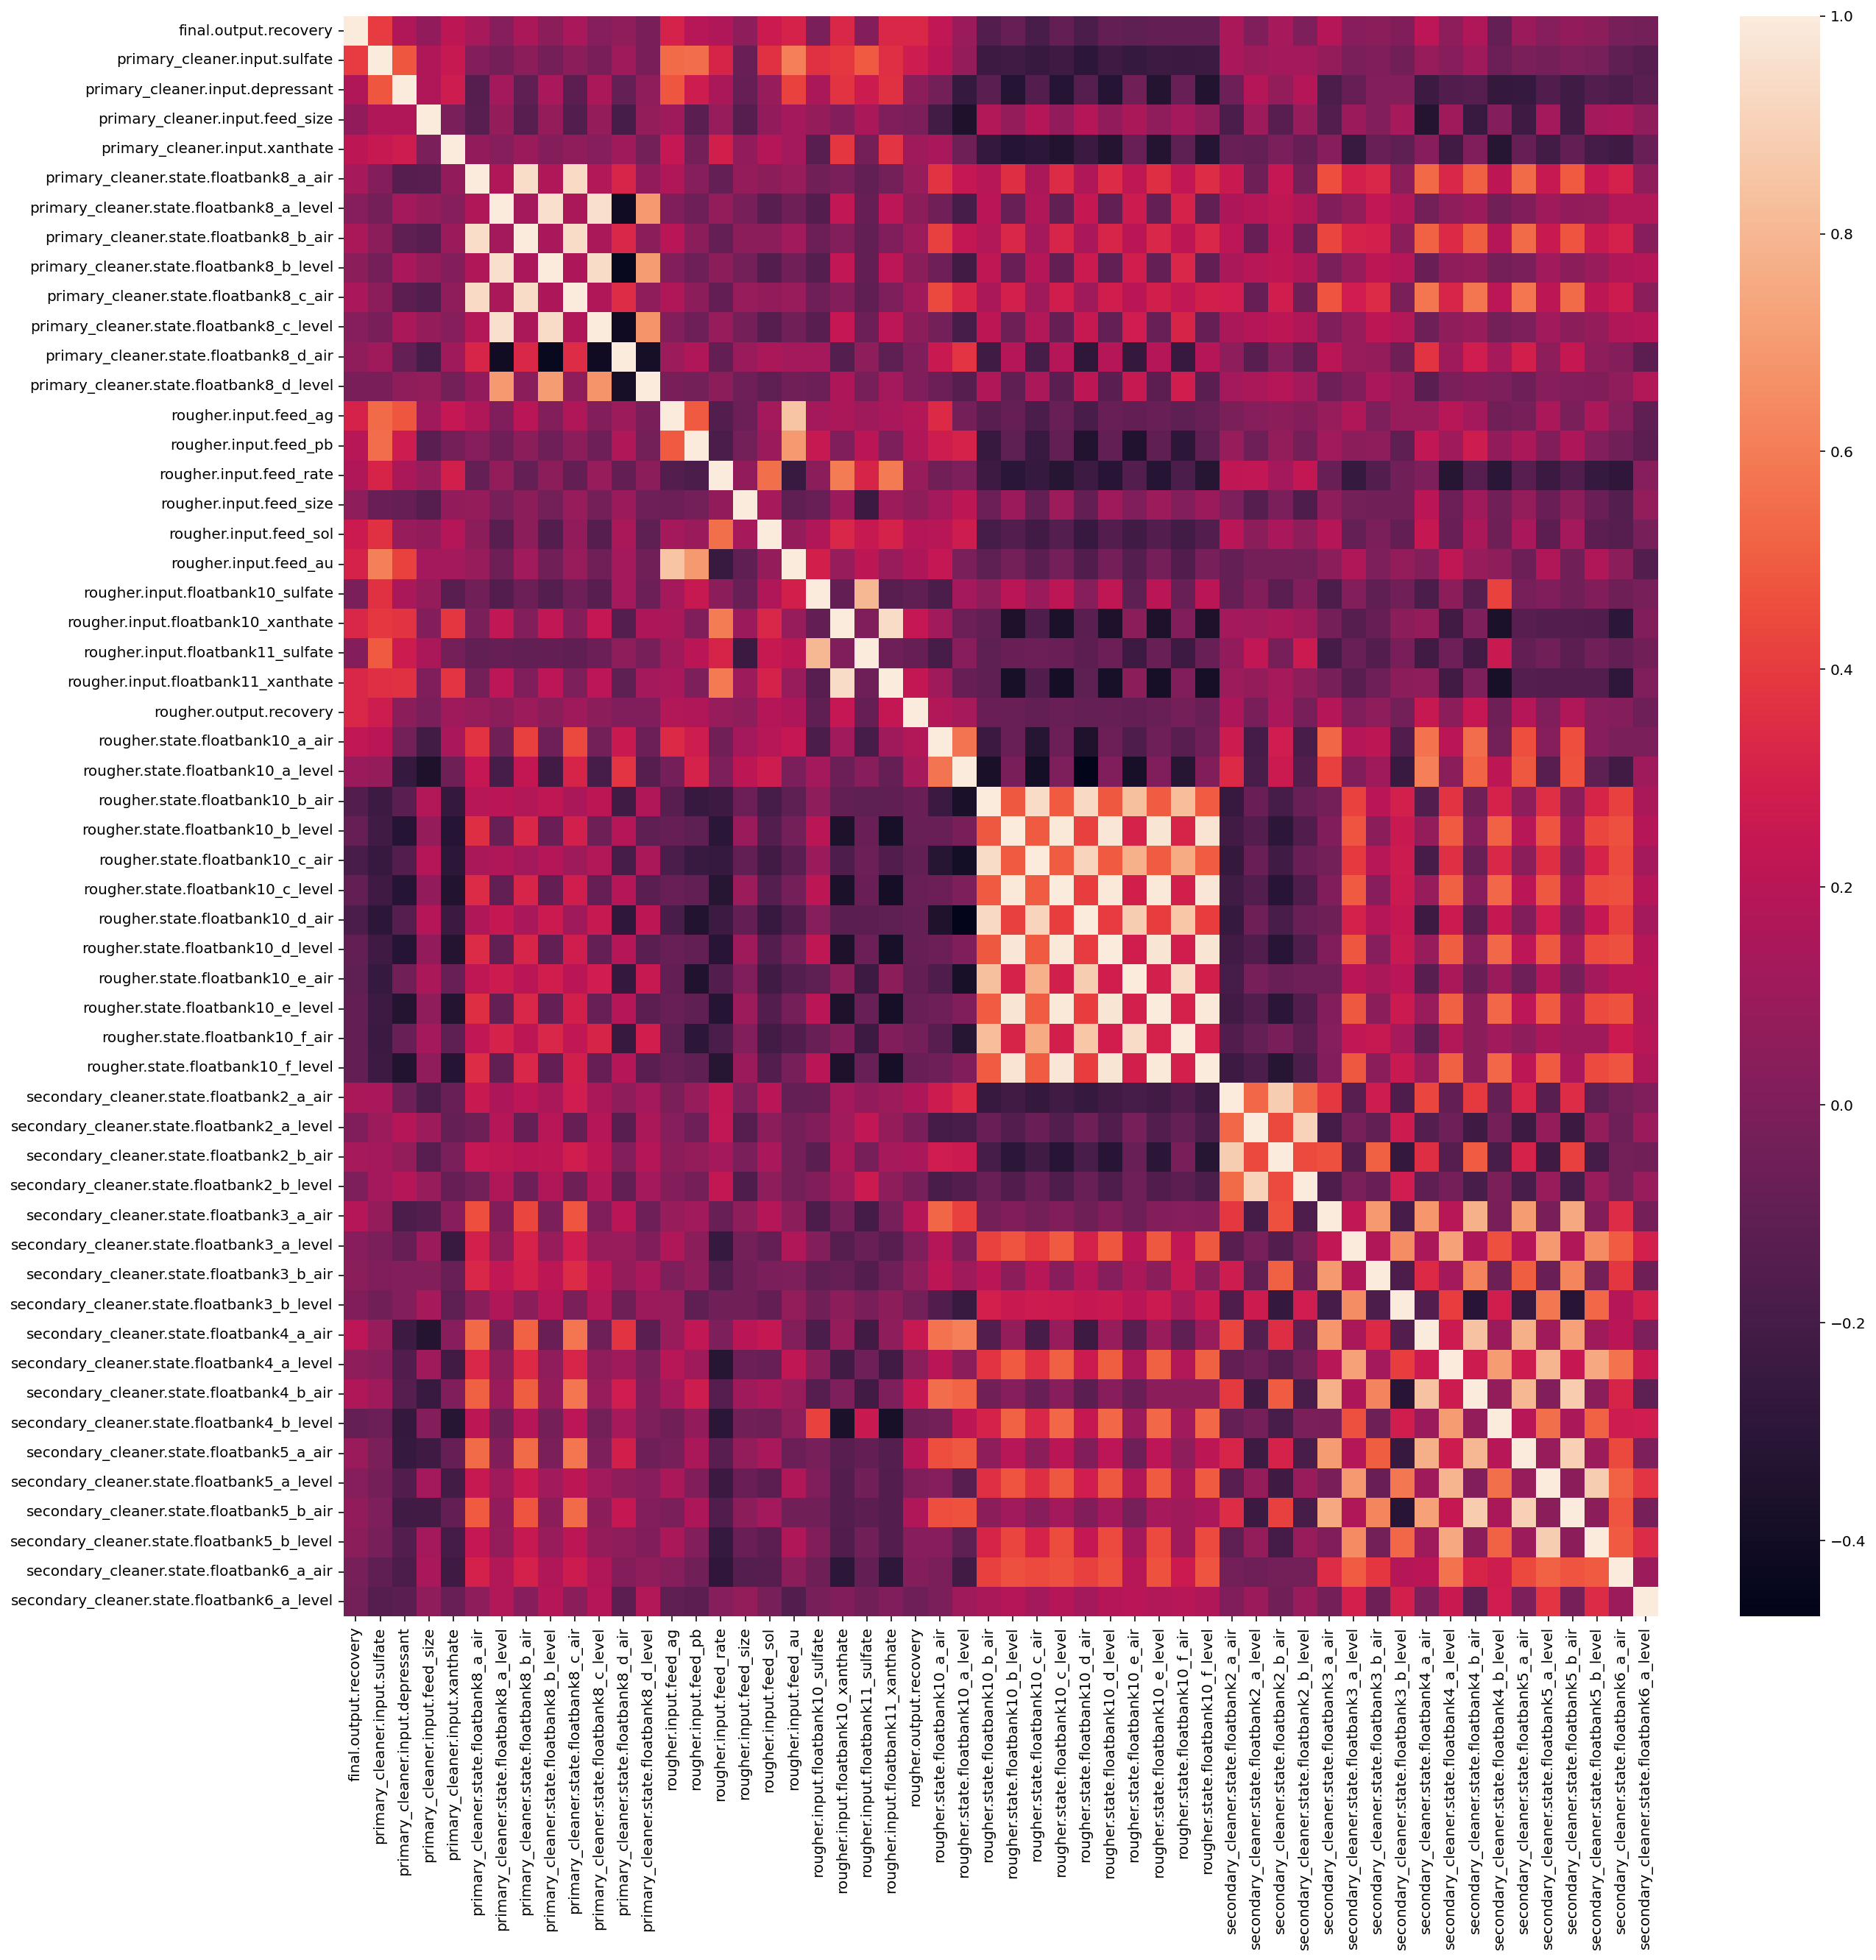

In [13]:
ind_to_w = [x for x in train.columns if x not in ex]
plt.figure(figsize=(20, 20))
sns.heatmap(train[ind_to_w].corr(), annot=False)

выделим 16 признаков с выраженной корреляцией, данные признаки характеризуют состояния промежуточных этапов. Не будем включать эти признаки при обучении модели

In [14]:
cols_with_corr = ['rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
                  'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
                  'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
                  'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
                  'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level',
                  'primary_cleaner.state.floatbank8_a_air',
                  'primary_cleaner.state.floatbank8_a_level',
                  'primary_cleaner.state.floatbank8_b_air',
                  'primary_cleaner.state.floatbank8_b_level',
                  'primary_cleaner.state.floatbank8_c_air',
                  'primary_cleaner.state.floatbank8_c_level']

In [15]:
train = train.drop(cols_with_corr, axis=1)

In [16]:
print(train['rougher.output.recovery'].isna().sum())
print(train['final.output.recovery'].isna().sum())

0
0


Пропуски отсутствуют в целевом признаке

Мы знаем, что соседние по времени параметры часто похожи. Запомним пропуски методом ffill

In [17]:
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')
full = full.fillna(method='ffill')

In [18]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())
print(full.isna().sum().sum())

0
0
0


## 2. Анализ данных

### Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки

In [19]:
def graph_(data, col0, col1, col2, col3, title):
    
    df0 = data[['date', col0]].rename(columns={col0:'Tap'})
    df0['step'] = 'input'
    df1 = data[['date', col1]].rename(columns={col1:'Tap'})
    df1['step'] = 'rougher'
    df2 = data[['date', col2]].rename(columns={col2:'Tap'})
    df2['step'] = 'primary_cleaner'
    df3 = data[['date', col3]].rename(columns={col3:'Tap'})
    df3['step'] = 'final'
    df=pd.concat([df0,df1,df2,df3]).reset_index()
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 7))
    sns.lineplot(x=df['date'], y=df['Tap'], hue=df['step'], ax=ax)
    ax.set(ylabel=None)
    ax.set_title(title, fontsize=24)
    plt.show()

In [20]:
# вывод графиков убран с целью облегчения файла
#graph_(full, 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 
#       'final.output.concentrate_au', 'Концентрация Au, full')
#graph_(full, 'rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 
#     'final.output.concentrate_ag', 'Концентрация Ag, full')
#graph_(full, 'rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 
#       'final.output.concentrate_pb', 'Концентрация Pb, full')

In [21]:
# вывод графиков убран с целью облегчения файла
#graph_(train, 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 
#       'final.output.concentrate_au', 'Концентрация Au, train')
#graph_(train, 'rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 
#     'final.output.concentrate_ag', 'Концентрация Ag, train')
#graph_(train, 'rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 
#       'final.output.concentrate_pb', 'Концентрация Pb, train')


Концентрация золота растет, серебра падает, свинца чаще растет по мере продвижения по технологическому процессу.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

In [22]:
for col in train.columns:
    if 'feed_size' in col:
        print(col)

primary_cleaner.input.feed_size
rougher.input.feed_size


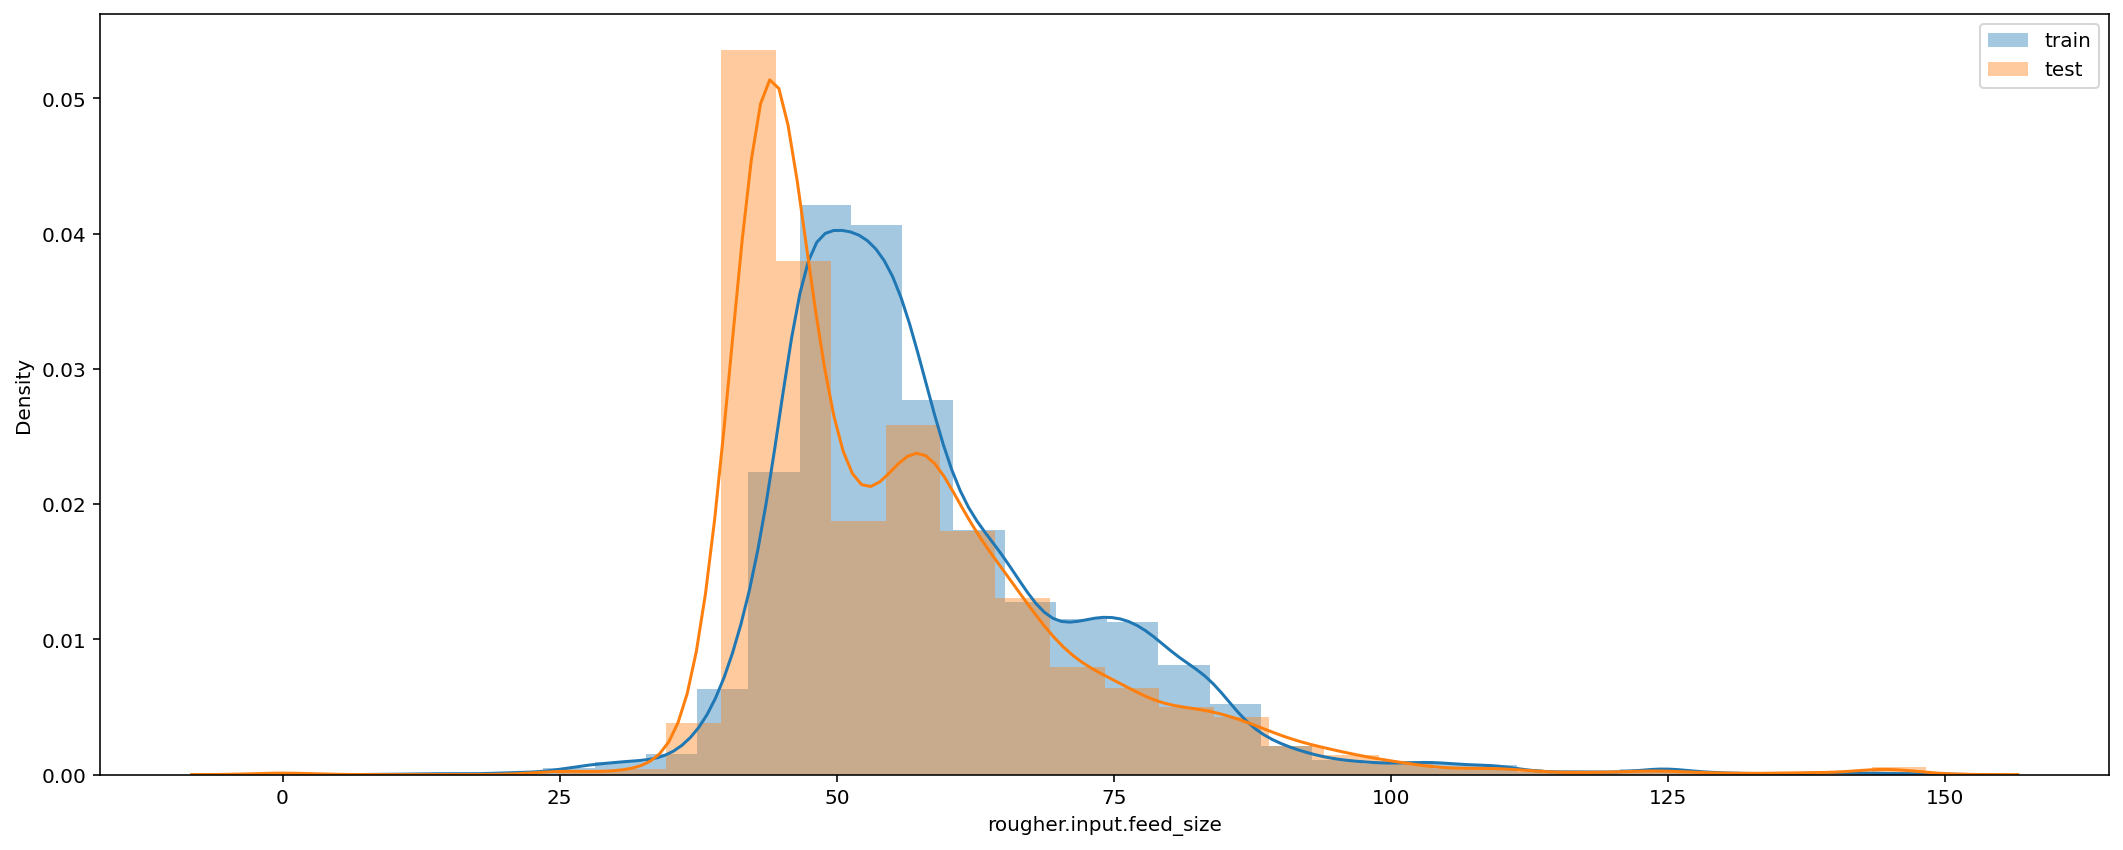

In [23]:
f, ax = plt.subplots(1, 1, figsize=(18, 7))
sns.distplot(train[train['rougher.input.feed_size'] < 150]['rougher.input.feed_size'], bins=30, label='train')
sns.distplot(test[test['rougher.input.feed_size'] < 150]['rougher.input.feed_size'], bins=30, label='test')
ax.legend()
plt.show()

In [24]:
len(train[train['rougher.input.feed_size'] < 150]) / len(train)

0.9921549226093717

In [25]:
len(test[test['rougher.input.feed_size'] < 150]) / len(test)

0.997164461247637

Гистограммы распределений говорят о схожести распределений. Не учтенные выбросы составляют не более 1,01% рассмотренных объемов

### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [26]:
def graph_con(data, title):    
    conc = []

    for col in data:
        if 'concentrate' in col and 'calculation' not in col:
            conc.append(col)

    concentrate = train[conc]

    concentrate['final'] = concentrate[conc[:4]].sum(axis=1)
    concentrate['primary_cleaner'] = concentrate[conc[4:8]].sum(axis=1)
    concentrate['rougher'] = concentrate[conc[8:]].sum(axis=1)
    concentrate = concentrate.drop(conc, axis=1)

    concentrate['date'] = train['date']  

    fig, ax = plt.subplots(1, 1, figsize=(20, 7))
    sns.lineplot(x=concentrate['date'], y=concentrate['rougher'], label='rougher', ax=ax)
    sns.lineplot(x=concentrate['date'], y=concentrate['primary_cleaner'], label='primary_cleaner', ax=ax)
    sns.lineplot(x=concentrate['date'], y=concentrate['final'], label='final', ax=ax)

    ax.legend()
    ax.set(ylabel=None)
    ax.set_title('Суммарная концентрация всех веществ, '+title, fontsize=24)
    plt.show()

In [27]:
# вывод графиков убран с целью облегчения файла
#graph_con(full, 'full')
#graph_con(train, 'train')

Ссумарная концентрация всех веществ в начале технологического процесса выше, чем после его завершения. 

Уберем из всех выборок записи для которых суммарная концентрация всех веществ составляет меньше 20 для этапов - rougher, primary_cleaner, final

In [28]:
print(len(full))

19439


In [29]:
cons_cols = [x for x in full if 'concentrate' in x and 'calculation' not in x]

len_or = len(full) 
len_n = len(full[(full[cons_cols[:4]].sum(axis=1)>20)&(full[cons_cols[4:8]].sum(axis=1)>20)&(full[cons_cols[8:]].sum(axis=1)>20)])
loss = 100*(len_or - len_n) / len_or
print('Записей для исключения из full: ', len_or - len_n)
print('% условных выбросов, full: ', round(loss, 1))

Записей для исключения из full:  848
% условных выбросов, full:  4.4


In [30]:
dates_to_exclude = \
full[~((full[cons_cols[:4]].sum(axis=1)>20)&(full[cons_cols[4:8]].sum(axis=1)>20)&   \
                                                         (full[cons_cols[8:]].sum(axis=1)>20))]['date']

In [31]:
l = len(test) - len(test.query('date not in @dates_to_exclude'))
print('Записей для исключения из test: ',  l)
print('% условных выбросов, test: ', round(100*l / len(test), 1))

Записей для исключения из test:  198
% условных выбросов, test:  3.7


In [32]:
l = len(train) - len(train.query('date not in @dates_to_exclude'))
print('Записей для исключения из train: ',  l)
print('% условных выбросов, train: ', round(100*l / len(train), 1))

Записей для исключения из train:  650
% условных выбросов, train:  4.6


In [33]:
full = full.query('date not in @dates_to_exclude')
test = test.query('date not in @dates_to_exclude')
train = train.query('date not in @dates_to_exclude')

In [34]:
# вывод графиков убран с целью облегчения файла
#graph_con(full, 'full')
#graph_con(train, 'train')

## 3. Модель

### Подготовим признаки для обучения и тестирования

cols_with_corr - 16 признаков с высокой корреляцией

In [35]:
ind_m = test.drop(cols_with_corr, axis=1).columns
feature_f = train[ind_m]
feature_f = feature_f.drop('date', axis=1)
target_f = train['final.output.recovery']
print(feature_f.shape)
print(target_f.shape)

(13499, 36)
(13499,)


In [36]:
cols_rougher = pd.Series([x for x in ind_m if 'rougher' in x])

In [37]:
feature_r = train[cols_rougher]
target_r = train['rougher.output.recovery']
print(feature_r.shape)
print(target_r.shape)

(13499, 12)
(13499,)


In [38]:
test_feature_f = test[ind_m]
test_feature_r = test[cols_rougher]
test_feature_f = test_feature_f.drop('date', axis=1)
print(test_feature_f.shape)
print(test_feature_r.shape)

(5092, 36)
(5092, 12)


In [39]:
test_true_r = test.merge(full, on='date')['rougher.output.recovery']
test_true_f = test.merge(full, on='date')['final.output.recovery']

### Определим функцию sMAPE, которая считает метрику качества модели

In [40]:
def smape(true, predict):
    return 1 / len(true) * sum( abs(true - predict) / ( (abs(true) + abs(predict)) * 0.5) ) * 100

def final_smape(smape_r, smape_f):
    return 0.25 * smape_r + 0.75 * smape_f

### Масштабирование данных

In [41]:
cols_r = feature_r.columns
cols_f = feature_f.columns

scaler_r = StandardScaler()
scaler_f = StandardScaler()
scaler_r.fit(feature_r)
scaler_f.fit(feature_f)

feature_r = pd.DataFrame(scaler_r.transform(feature_r), columns=cols_r)
feature_f = pd.DataFrame(scaler_f.transform(feature_f), columns=cols_f)

test_feature_f = pd.DataFrame(scaler_f.transform(test_feature_f), columns=cols_f)
test_feature_r = pd.DataFrame(scaler_r.transform(test_feature_r), columns=cols_r)

### Оценка качества моделей

**LinearRegression**

In [42]:
lr_r = LinearRegression()
smape_lr_r = cross_val_score(lr_r, feature_r, target_r, scoring = make_scorer(smape), cv = 5, n_jobs = -1).mean()
print('sMAPE, rougher :', round(smape_lr_r, 2))

lr_f = LinearRegression()
smape_lr_f = cross_val_score(lr_f, feature_f, target_f, scoring = make_scorer(smape), cv = 5, n_jobs = -1).mean()
print('sMAPE, end :', round(smape_lr_f, 2))
print('final sMAPE :', round(final_smape(smape_lr_r, smape_lr_f),2))

sMAPE, rougher : 6.38
sMAPE, end : 10.19
final sMAPE : 9.24


**RandomForestRegressor**

In [43]:
rf_r = RandomForestRegressor(random_state=12345, n_estimators=5, max_depth=3, min_samples_leaf=2)
smape_rf_r = cross_val_score(rf_r, feature_r, target_r, scoring = make_scorer(smape), cv = 5, n_jobs = -1).mean()
print('sMAPE, rougher :', round(smape_rf_r, 2))

rf_f = RandomForestRegressor(random_state=12345, n_estimators=5, max_depth=3, min_samples_leaf=2)
smape_rf_f = cross_val_score(rf_f, feature_f, target_f, scoring = make_scorer(smape), cv = 5, n_jobs = -1).mean()
print('sMAPE, end :', round(smape_rf_f, 2))
print('final sMAPE :', round(final_smape(smape_rf_r, smape_rf_f),2))

sMAPE, rougher : 6.18
sMAPE, end : 8.83
final sMAPE : 8.17


**CatBoostRegressor**

In [44]:
catb_r = CatBoostRegressor(iterations=3, verbose=False, random_state=12345)
smape_catb_r = cross_val_score(catb_r, feature_r, target_r, scoring = make_scorer(smape), cv = 5, n_jobs = -1).mean()
print('sMAPE, rougher :', round(smape_catb_r, 2))

catb_f = CatBoostRegressor(iterations=3, verbose=False, random_state=12345)
smape_catb_f = cross_val_score(catb_f, feature_f, target_f, scoring = make_scorer(smape), cv = 5, n_jobs = -1).mean()
print('sMAPE, end :', round(smape_catb_f, 2))
print('final sMAPE :', round(final_smape(smape_catb_r, smape_catb_f),2))

sMAPE, rougher : 5.77
sMAPE, end : 8.89
final sMAPE : 8.11


При обучении на кросс валидации лучшую итоговую метрику показывает модель CatBoostRegressor

**DummyRegressor**

In [45]:
dummy_r = DummyRegressor()
smape_dummy_r = cross_val_score(dummy_r, feature_r, target_r, scoring = make_scorer(smape), cv = 5, n_jobs = -1).mean()
print('sMAPE, rougher :', round(smape_dummy_r, 2))

dummy_f = DummyRegressor()
smape_dummy_f = cross_val_score(dummy_f, feature_f, target_f, scoring = make_scorer(smape), cv = 5, n_jobs = -1).mean()
print('sMAPE, end :', round(smape_dummy_f, 2))
print('final sMAPE :', round(final_smape(smape_dummy_r, smape_dummy_f),2))

sMAPE, rougher : 7.71
sMAPE, end : 10.19
final sMAPE : 9.57


Подберем гиперпараметры для CatBoostRegressor

In [46]:
score = make_scorer(smape, greater_is_better=False)

In [47]:
grid = {'iterations': [x for x in range(2, 7)],  'learning_rate': [0.15, 0.25, 0.3, 0.4, 0.5, 0.6], 
         'depth':[x for x in range(2,5)],  'l2_leaf_reg': [0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1]}
                                         
model = CatBoostRegressor(random_state=12345, verbose=False)

grid_search = GridSearchCV(model, grid, scoring=score, cv=5)

grid_search.fit(feature_f, target_f)

print(grid_search.best_params_)

{'depth': 4, 'iterations': 6, 'l2_leaf_reg': 0.3, 'learning_rate': 0.4}


### Тестирование моделей

**LinearRegression**

In [48]:
mod_r = LinearRegression()
mod_r.fit(feature_r, target_r)
predict_r = pd.Series(mod_r.predict(test_feature_r))
print('sMAPE, rougher :', round(smape(test_true_r, predict_r), 2))

mod_f = LinearRegression()
mod_f.fit(feature_f, target_f)
predict_f = mod_f.predict(test_feature_f)
print('sMAPE, end :', round(smape(test_true_f, predict_f), 2))
print('final sMAPE :', round(final_smape(smape(test_true_r, predict_r), smape(test_true_f, predict_f)),2))


sMAPE, rougher : 4.45
sMAPE, end : 7.83
final sMAPE : 6.98


**RandomForestRegressor**

In [49]:
mod_r = RandomForestRegressor(random_state=12345, n_estimators=5, max_depth=3, min_samples_leaf=2)
mod_r.fit(feature_r, target_r)
predict_r = mod_r.predict(test_feature_r)
print('sMAPE, rougher :', round(smape(test_true_r, predict_r), 2))

mod_f = RandomForestRegressor(random_state=12345, n_estimators=5, max_depth=3, min_samples_leaf=2)
mod_f.fit(feature_f, target_f)
predict_f = mod_f.predict(test_feature_f)
print('sMAPE, end :', round(smape(test_true_f, predict_f), 2))
print('final sMAPE :', round(final_smape(smape(test_true_r, predict_r), smape(test_true_f, predict_f)),2))


sMAPE, rougher : 4.82
sMAPE, end : 7.97
final sMAPE : 7.18


**CatBoostRegressor**

In [50]:
mod_r = CatBoostRegressor(iterations=3, verbose=False, random_state=12345)
mod_r.fit(feature_r, target_r)
predict_r = mod_r.predict(test_feature_r)
print('sMAPE, rougher :', round(smape(test_true_r, predict_r), 2))

mod_f = CatBoostRegressor(iterations=3, verbose=False, random_state=12345)
mod_f.fit(feature_f, target_f)
predict_f = mod_f.predict(test_feature_f)
print('sMAPE, end :', round(smape(test_true_f, predict_f), 2))
print('final sMAPE :', round(final_smape(smape(test_true_r, predict_r), smape(test_true_f, predict_f)),2))

sMAPE, rougher : 4.1
sMAPE, end : 7.44
final sMAPE : 6.61


**DummyRegressor**

In [51]:
mod_r = DummyRegressor()
mod_r.fit(feature_r, target_r)
predict_r = mod_r.predict(test_feature_r)
print('sMAPE, rougher :', round(smape(test_true_r, predict_r), 2))

mod_f = DummyRegressor()
mod_f.fit(feature_f, target_f)
predict_f = mod_f.predict(test_feature_f)
print('sMAPE, end :', round(smape(test_true_f, predict_f), 2))
print('final sMAPE :', round(final_smape(smape(test_true_r, predict_r), smape(test_true_f, predict_f)),2))

sMAPE, rougher : 5.23
sMAPE, end : 8.53
final sMAPE : 7.71


**Посмотрим на результаты CatBoostRegressor c подобранными гиперпараметрами**

Обучение

In [52]:
catb_r = CatBoostRegressor(iterations=6, depth=4, l2_leaf_reg=0.3, verbose=False, learning_rate=0.4, random_state=12345)
smape_catb_r = cross_val_score(catb_r, feature_r, target_r, scoring = score, cv = 5, n_jobs = -1).mean()
print('sMAPE, rougher :', abs(round(smape_catb_r, 2)))

catb_f = CatBoostRegressor(iterations=6, depth=4, l2_leaf_reg=0.3, verbose=False, learning_rate=0.4, random_state=12345)
smape_catb_f = cross_val_score(catb_f, feature_f, target_f, scoring = score, cv = 5, n_jobs = -1).mean()
print('sMAPE, end :', abs(round(smape_catb_f, 2)))
print('final sMAPE :', abs(round(final_smape(smape_catb_r, smape_catb_f),2)))

sMAPE, rougher : 5.64
sMAPE, end : 8.66
final sMAPE : 7.91


Тестирование

In [53]:
mod_r = CatBoostRegressor(iterations=6, depth=4, l2_leaf_reg=0.3, verbose=False, learning_rate=0.4, random_state=12345)
mod_r.fit(feature_r, target_r)
predict_r = mod_r.predict(test_feature_r)
print('sMAPE, rougher :', round(smape(test_true_r, predict_r), 2))

mod_f = CatBoostRegressor(iterations=6, depth=4, l2_leaf_reg=0.3, verbose=False, learning_rate=0.4, random_state=12345)
mod_f.fit(feature_f, target_f)
predict_f = mod_f.predict(test_feature_f)
print('sMAPE, end :', round(smape(test_true_f, predict_f), 2))
print('final sMAPE :', round(final_smape(smape(test_true_r, predict_r), smape(test_true_f, predict_f)),2))

sMAPE, rougher : 3.89
sMAPE, end : 6.96
final sMAPE : 6.19


## Заключение

Рассмотрены три модели LinearRegression, RandomForestRegressor, CatBoostRegressor. Все три модели выдают результат лучший, чем константная модель. Лучший показатель sMAPE получен на модели CatBoostRegressor - 7,91 и 6,19 на тренировочной и тестовой выборках соответственно.